# Visualize results

## Plot histogram <a name='histogram'></a>

The `plot_histogram` function visualizes the result of sampling a quantum circuit on a QPU or simulator.

<Admonition title="Using the output from functions" type="tip">
This function returns a `matplotlib.Figure` object. When the last line of a code cell outputs these objects, Jupyter notebooks display them below the cell. If you call these functions in some other environments or in scripts, you will need to explicitly show or save the outputs.

Two options are:
- Call `.show()` on the returned object to open the image in a new window (assuming your configured matplotlib backend is interactive).
- Call `.savefig("out.png")` to save the figure to `out.png` in the current working directory. The `savefig()` method takes a path so you can adjust the location and filename where you're saving the output. For example, `plot_state_city(psi).savefig("out.png")`.
</Admonition>

For example, make a two-qubit Bell state:

In [1]:
from qiskit_aer.primitives import Sampler

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram

In [2]:
# quantum circuit to make a Bell state
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()

# execute the quantum circuit
quasi_dists = Sampler().run(bell, shots=1000).result().quasi_dists[0]
print(quasi_dists)

{0: 0.497, 3: 0.503}


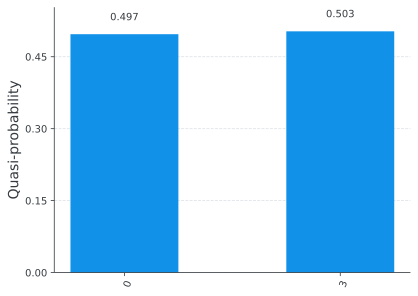

In [3]:
plot_histogram(quasi_dists)

### Options when plotting a histogram

Use the following options for `plot_histogram` to adjust the output graph.

* `legend`: Provides a label for the executions. It takes a list of strings used to label each execution's results. This is mostly useful when plotting multiple execution results in the same histogram
* `sort`: Adjusts the order of the bars in the histogram. It can be set to either ascending order with `asc` or descending order with `desc`
* `number_to_keep`: Takes an integer for the number of terms to show. The rest are grouped together in a single bar called "rest"
* `color`: Adjusts the color of the bars; takes a string or a list of strings for the colors to use for the bars for each execution
* `bar_labels`: Adjusts whether labels are printed above the bars
* `figsize`: Takes a tuple of the size in inches to make the output figure

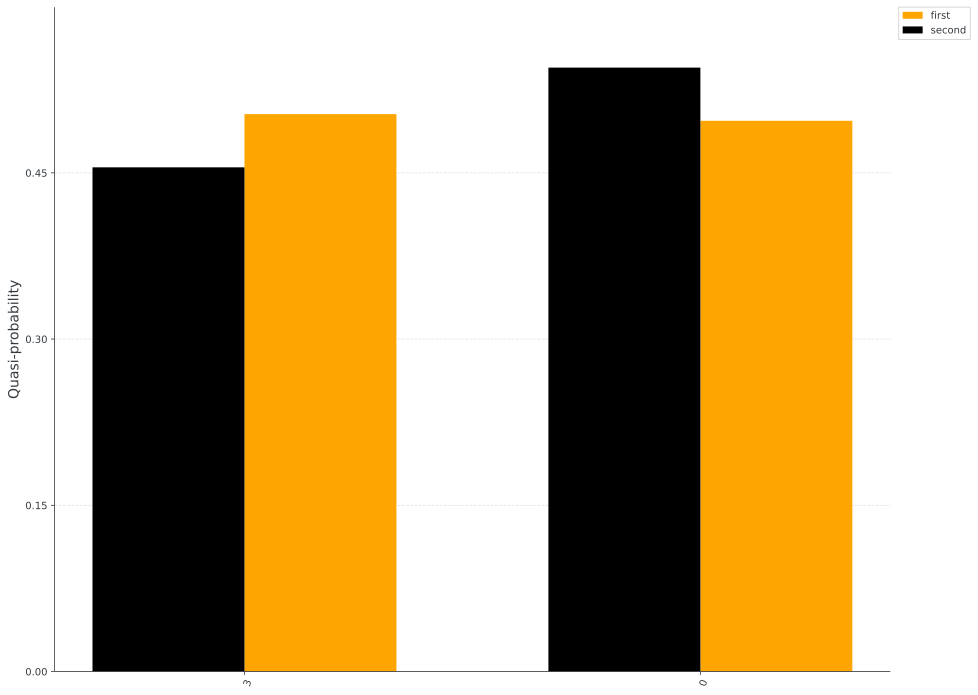

In [4]:
# Execute two-qubit Bell state again
second_quasi_dists = Sampler().run(bell, shots=1000).result().quasi_dists[0]

# Plot results with custom options
plot_histogram(
    [quasi_dists, second_quasi_dists],
    legend=["first", "second"],
    sort="desc",
    figsize=(15, 12),
    color=["orange", "black"],
    bar_labels=False,
)

## Plotting estimator results

Qiskit does not have a built-in function for plotting `Estimator` results, but you can use Matplotlib's [`bar` plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) for a quick visualization.

To demonstrate, the following cell estimates the expectation values of seven different observables on a quantum state.

EstimatorResult(values=array([ 0.47070312,  0.015625  ,  0.515625  ,  0.01757812, -0.70703125,
        0.01171875,  0.70507812]), metadata=[{'shots': 1024, 'variance': 0.7784385681152344, 'simulator_metadata': [{'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 16, 'parallel_shots': 1, 'sample_measure_time': 0.020288216, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 0.04090926, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 32768, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'statevector', 'required_memory_mb': 1, 'fusion': {'enabled': True, 'threshold': 14, 'applied': False, 'max_fused_qubits': 5}}]}, {'shots': 1024, 'variance': 0.999755859375, 'simulator_metadata': [{'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 16, 'parallel_shots': 1, 'sample_measure_time': 0.020340968, 'noise': 'ideal', 'bat

<BarContainer object of 7 artists>

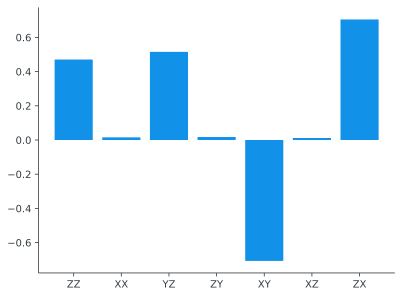

In [5]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator

# Simple estimation experiment to create results
qc = QuantumCircuit(2)
qc.h(0)
qc.crx(1.5, 0, 1)

observables_labels = ["ZZ", "XX", "YZ", "ZY", "XY", "XZ", "ZX"]
observables = [SparsePauliOp(label) for label in observables_labels]

result = Estimator().run([qc]*7, observables).result()
print(result)

# Plot using Matplotlib
from matplotlib import pyplot as plt
plt.bar(observables_labels, result.values)

The following cell estimates the [standard error](https://en.wikipedia.org/wiki/Standard_error) from the [variance](https://en.wikipedia.org/wiki/Variance) of each result and adds them as error bars. See the [`bar` plot documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) for a full description of the plot.

Text(0.5, 1.0, 'Expectation values (with standard errors)')

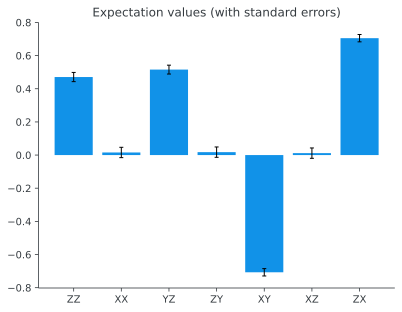

In [6]:
from math import sqrt
standard_error = [sqrt(exp_data["variance"])/sqrt(exp_data["shots"]) for exp_data in result.metadata]

_, ax = plt.subplots()
ax.bar(observables_labels, result.values, yerr=standard_error, capsize=2)
ax.set_title("Expectation values (with standard errors)")